In [107]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import statsmodels.graphics.tsaplots as sgt

In [2]:
data =  pd.read_csv('ghana_gdp.zip', parse_dates=["year"], index_col = ["year"])
data.head()

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


<AxesSubplot:xlabel='year'>

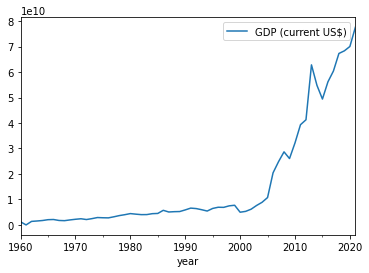

In [3]:
%matplotlib inline 
data.plot()

Отложим три последних года датасета как тестовую выборку для оценки результатов предстказания

In [4]:
test_df = data.iloc[-3:]
train_df = data.iloc[:-3]

Сезонная декомпозиция ряда

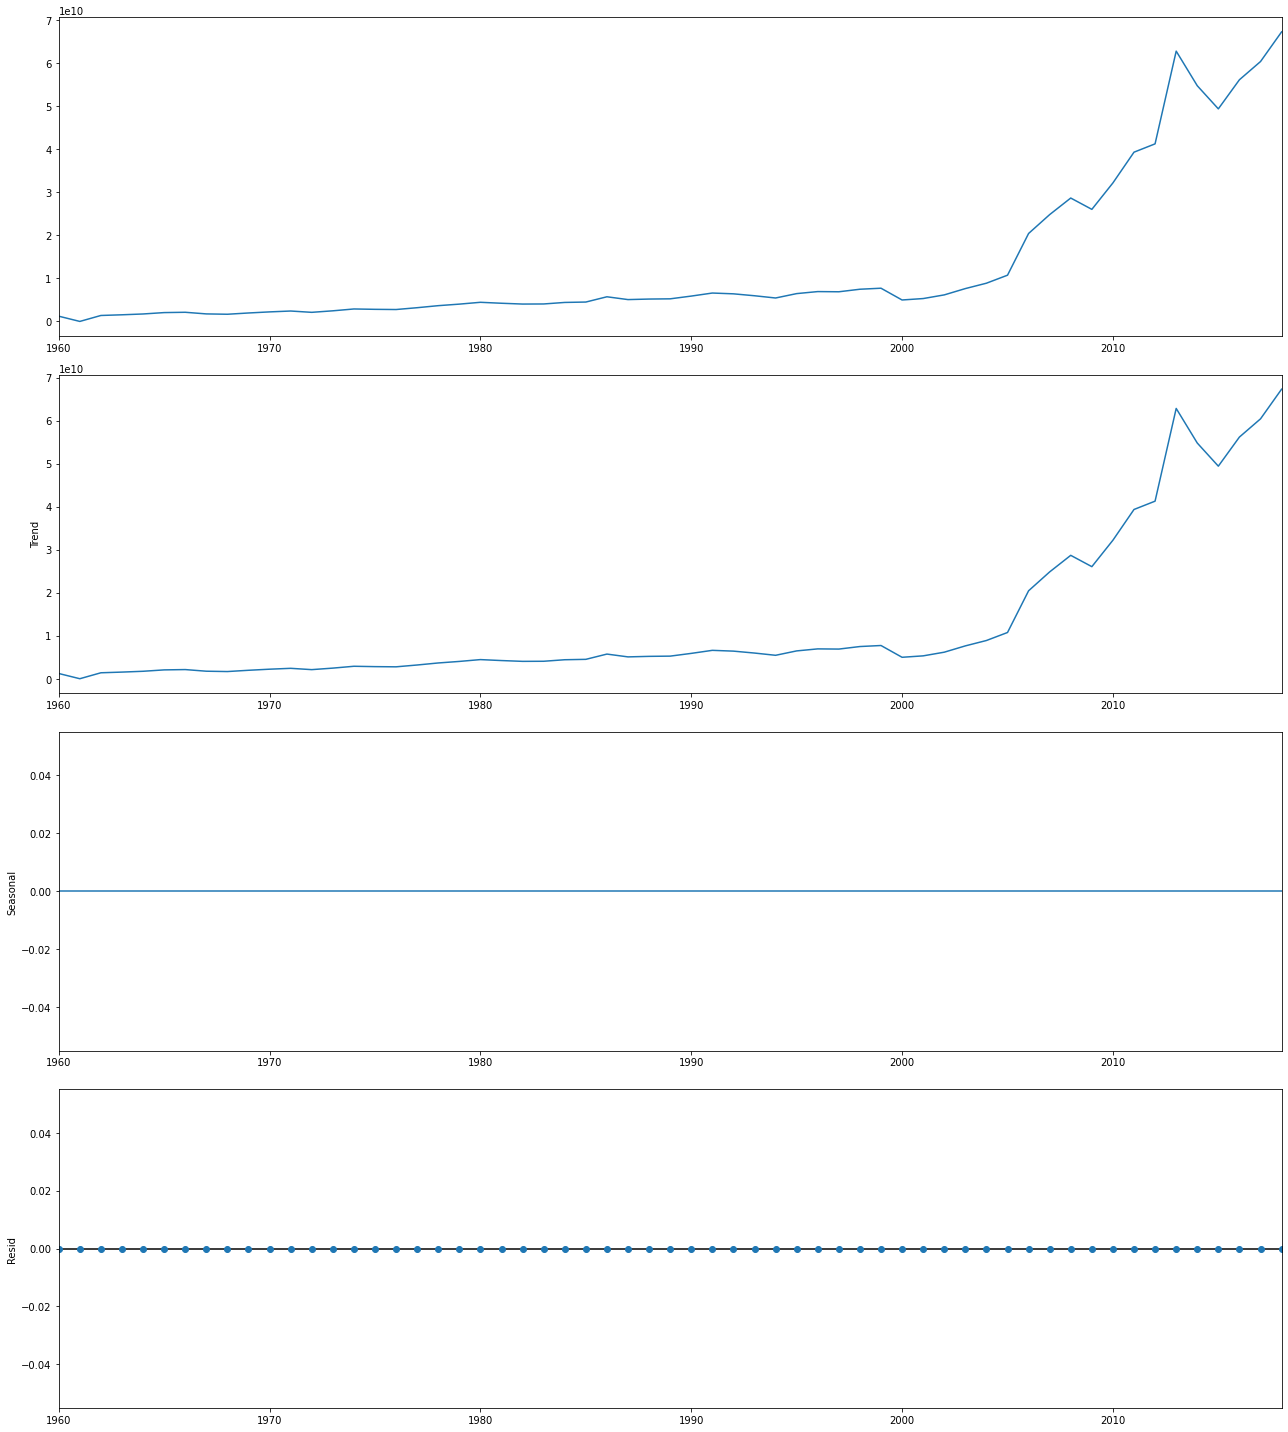

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

plt.rcParams["figure.figsize"] = 18, 20

result = seasonal_decompose(train_df, model='additive')
result.plot()
plt.show()

По графикам можно заметить, что по нашим данным не выделяется сезонности, а остатки расположены около нуля

Построим скользящее среднее с окном в 20 и 50 дней

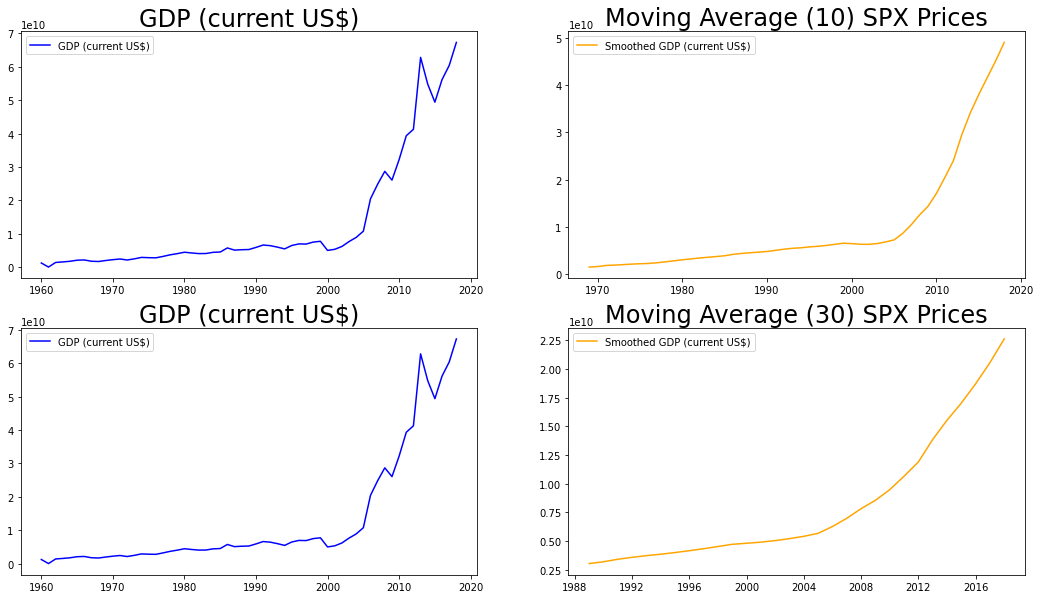

In [68]:
plt.rcParams["figure.figsize"] = 18, 10

fig, ax = plt.subplots(2, 2)

# Окно в месяц (Window = 30) 
ax[0, 0].plot(train_df[['GDP (current US$)']], color = "blue", label = "GDP (current US$)")
ax[0, 0].set_title("GDP (current US$)", size = 24)
ax[0, 0].legend()

ax[0, 1].plot(train_df[['GDP (current US$)']].rolling(window=10).mean(), color = "orange", label = "Smoothed GDP (current US$)")
ax[0, 1].set_title("Moving Average (10) SPX Prices", size = 24)
ax[0, 1].legend()


# Окно в год (Window = 300)
ax[1, 0].plot(train_df[['GDP (current US$)']], color = "blue", label = "GDP (current US$)")
ax[1, 0].set_title("GDP (current US$)", size = 24)
ax[1, 0].legend()

ax[1, 1].plot(train_df[['GDP (current US$)']].rolling(window=30).mean(), color = "orange", label = "Smoothed GDP (current US$)")
ax[1, 1].set_title("Moving Average (30) SPX Prices", size = 24)
ax[1, 1].legend()

График скользящего среднего с окном в 10 дней лучше описывает наш тренд

Построим колелограмму для нашего временного ряда

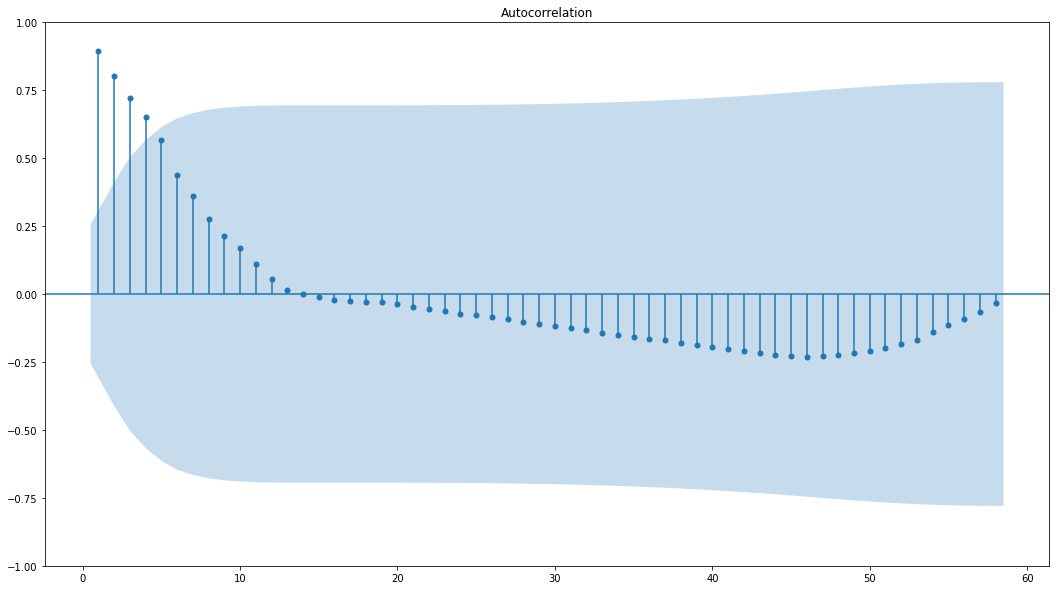

In [67]:
sgt.plot_acf(train_df[['GDP (current US$)']], zero = False, lags = 58)
plt.show()

Прослеживается четкая корреляция для первых 4 лагов

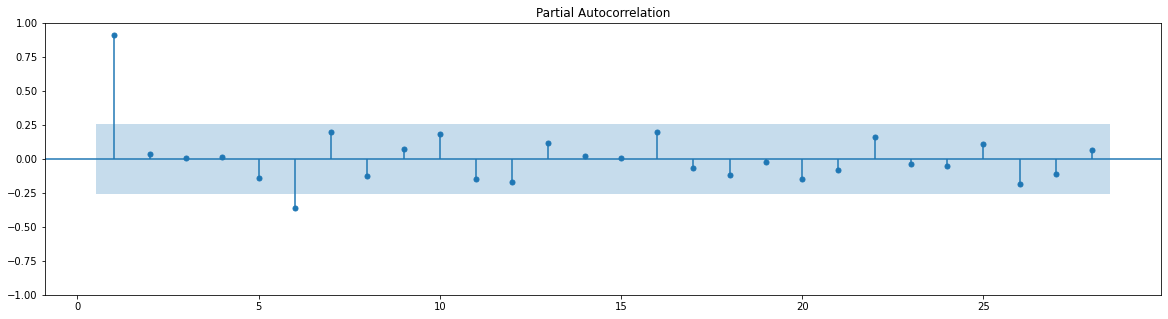

In [70]:
plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_pacf(train_df[['GDP (current US$)']], zero = False, lags = 28)
plt.show()

По графику частичной автокорреляции параметр p равен  6

In [71]:
from statsmodels.tsa.stattools import adfuller

adfuller(train_df["GDP (current US$)"])

(0.652906697488535,
 0.9888496277665572,
 10,
 48,
 {'1%': -3.5745892596209488,
  '5%': -2.9239543084490744,
  '10%': -2.6000391840277777},
 2194.301372914139)

Статистика теста больше всех критических значений, поэтому нулевую гипотезу ($H_0$) нельзя отвергнуть.

Поэтому значения GDP не являются стационарными

In [76]:
def plot_acf_pacf(series):
    plt.rcParams["figure.figsize"] = 18, 5

    fig, axes = plt.subplots(1, 2)
    
    sgt.plot_acf(series, lags = 40, ax = axes[0])
    sgt.plot_pacf(series, lags = 27, ax = axes[1])
    plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


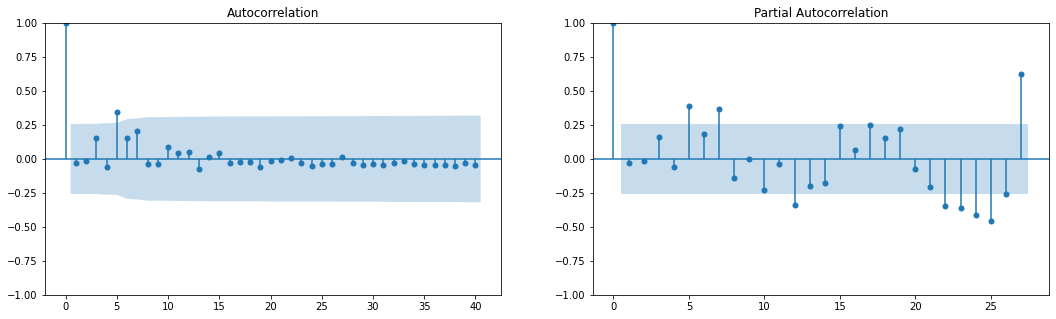

(-1.6702483038320795,
 0.44650293297138816,
 7,
 50,
 {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616},
 2147.2038799920597)

In [78]:
plot_acf_pacf(train_df["GDP (current US$)"].diff(1).dropna())
adfuller(train_df["GDP (current US$)"].diff(1).dropna())

Первые разности не являются стационарными

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


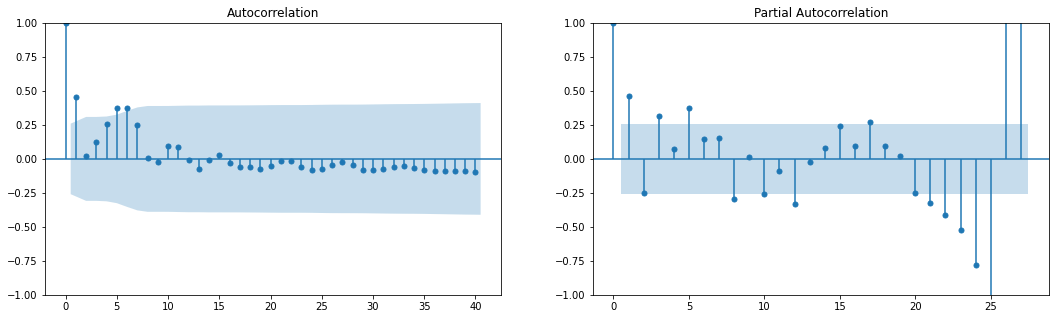

(-3.5836708658260252,
 0.00608098975387705,
 11,
 45,
 {'1%': -3.584828853223594,
  '5%': -2.9282991495198907,
  '10%': -2.6023438271604937},
 2100.77968010473)

In [79]:
plot_acf_pacf(train_df["GDP (current US$)"].diff(2).dropna())
adfuller(train_df["GDP (current US$)"].diff(2).dropna())

Вторые разности являются стационарными

In [126]:
from statsmodels.tsa.ar_model import AutoReg

ar_model = AutoReg(train_df["GDP (current US$)"].dropna(), lags=6).fit()
ar_model.summary()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                     AutoReg(6)   Log Likelihood               -1240.636
Method:               Conditional MLE   S.D. of innovations     3546731366.478
Date:                Thu, 13 Oct 2022   AIC                           2497.272
Time:                        11:46:07   BIC                           2513.035
Sample:                    01-01-1966   HQIC                          2503.334
                         - 01-01-2018                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  4.51e+08    6.6e+08      0.684      0.494   -8.42e+08    1.74e+09
GDP (current US$).L1     0.9264      0.140      6.625      0.000       0.652       1.200
GDP (current US$).L2    -0.0694      0.181     -0.383      0.702      -0.425       0.286
GDP (current US$).L3     0.2462      0.177      1.393      0.164      -0.100       0.593
GDP (current US$).L4    -0.1944      0.196     -0.991      0.322      -0.579       0.190
GDP (current US$).L5     0.4409      0.201      2.189      0.029       0.046       0.836
GDP (current US$).L6    -0.2727      0.313     -0.872      0.383      -0.886       0.340
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.8916           -0.7961j            1.1953           -0.3840
AR.2           -0.8916           +0.7961j            1.1953            0.3840
AR.3            0.4170           -1.2263j            1.2952           -0.1978
AR.4            0.4170           +1.2263j            1.2952            0.1978
AR.5            0.9418           -0.0000j            0.9418           -0.0000
AR.6            1.6242           -0.0000j            1.6242           -0.0000
-----------------------------------------------------------------------------
"""

In [125]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(train_df["GDP (current US$)"].diff(2).dropna(), order = (6, 2, 5))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimi

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   57
Model:                 ARIMA(6, 2, 5)   Log Likelihood               -1282.733
Date:                Thu, 13 Oct 2022   AIC                           2589.467
Time:                        11:45:54   BIC                           2613.555
Sample:                    01-01-1962   HQIC                          2598.782
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5623      0.220     -7.096      0.000      -1.994      -1.131
ar.L2         -2.0182      0.390     -5.181      0.000      -2.782      -1.255
ar.L3         -2.0905      0.498     -4.195      0.000      -3.067      -1.114
ar.L4         -1.9477      0.357     -5.450      0.000      -2.648      -1.247
ar.L5         -1.4146      0.289     -4.899      0.000      -1.981      -0.849
ar.L6         -0.8394      0.221     -3.806      0.000      -1.272      -0.407
ma.L1          0.7518      2.713      0.277      0.782      -4.565       6.068
ma.L2         -0.4214      2.252     -0.187      0.852      -4.835       3.992
ma.L3         -0.0445      1.358     -0.033      0.974      -2.706       2.617
ma.L4         -0.5117      1.881     -0.272      0.786      -4.198       3.175
ma.L5         -0.7570      0.380     -1.993      0.046      -1.501      -0.012
sigma2      9.285e+18   2.41e-19   3.85e+37      0.000    9.28e+18    9.28e+18
===================================================================================
Ljung-Box (L1) (Q):                   0.34   Jarque-Bera (JB):                39.34
Prob(Q):                              0.56   Prob(JB):                         0.00
Heteroskedasticity (H):             141.46   Skew:                            -0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number  2e+54. Standard errors may be unstable.
"""

На основе коэффициента AIC лучшая модель ARMA

Сделаем предсказание на три года

In [159]:
ar_pred = test_df.copy()
ar_pred["Predictions"] = ar_model.predict(start=test_df.index[0], end=test_df.index[-1], dynamic=False)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


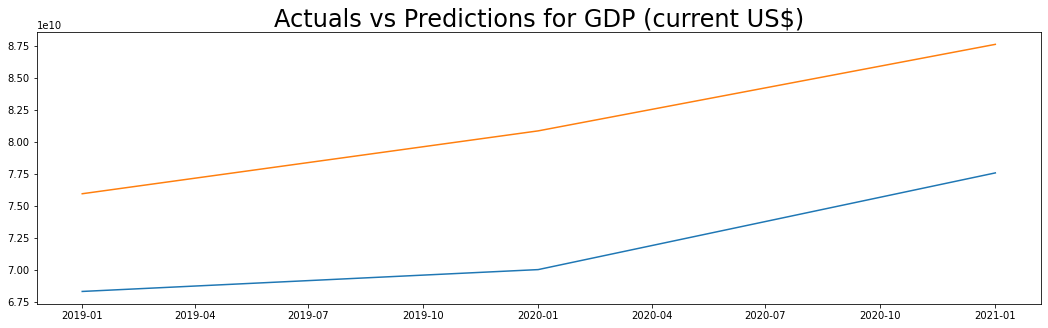

In [160]:
plt.rcParams["figure.figsize"] = 18, 5

plt.plot(test_df["GDP (current US$)"].abs())
plt.plot(ar_pred["Predictions"])

plt.title("Actuals vs Predictions for GDP (current US$)", size = 24)

plt.show()

In [90]:
pred_df = pd.DataFrame(index = test_df.index)
pred_df["model_preds"] = arima_model_fit.predict(start = test_df.index[0], end = test_df.index[-1])


pred_df["GDP (current US$)"] = data["GDP (current US$)"]

forecast = arima_model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha = 0.05) # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower GDP (current US$)"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper GDP (current US$)"]

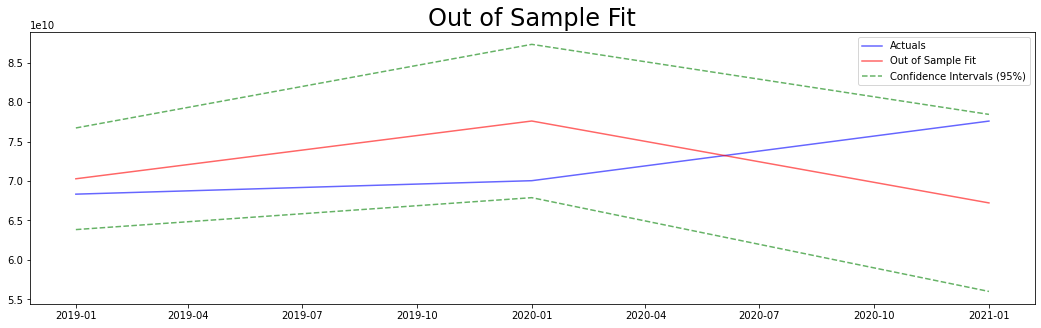

In [91]:
plt.plot(pred_df.loc[test_df.index]["GDP (current US$)"], color = "blue", label = "Actuals", alpha = 0.6)
plt.plot(pred_df.loc[test_df.index]["model_preds"], color = "red", linestyle = "-", label = "Out of Sample Fit", alpha = 0.6)
plt.plot(pred_df.loc[test_df.index]["model_preds_lower"], color = "green", linestyle = "--", label = "Confidence Intervals (95%)", alpha = 0.6)
plt.plot(pred_df.loc[test_df.index]["model_preds_upper"], color = "green", linestyle = "--", alpha = 0.6)
plt.title("Out of Sample Fit", size = 24)
plt.legend()

plt.show()

Модель ARMA лучше уловила поведение данных и предсказала данные для трех лет, чем модель ARIMA

### Построение модели после интерполяции данных

Проверим данные на наличие пропущенных дат


<AxesSubplot:xlabel='year'>

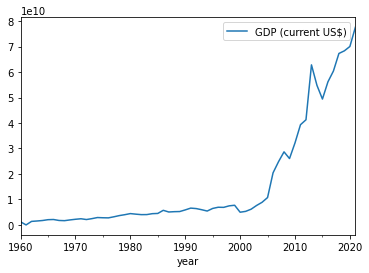

In [108]:
%matplotlib inline 
data.plot()

In [104]:
data.asfreq(freq='AS')

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09
...,...
2017-01-01,6.040638e+10
2018-01-01,6.729928e+10
2019-01-01,6.833754e+10


Получается, что в 1961 году значение GDP равнялось 0

In [105]:
data.isna().sum()

GDP (current US$)    0
dtype: int64

Пропущенных значений нет

In [109]:
data['GDP (current US$)'] = data['GDP (current US$)'].apply(lambda x: np.nan if x==0 else x)

(62, 1)


<AxesSubplot:xlabel='year'>

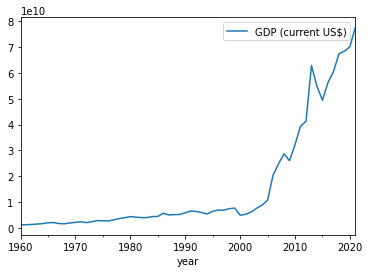

In [110]:
interpolated_data = pd.DataFrame(data['GDP (current US$)'].interpolate(method = 'linear'), columns = ["GDP (current US$)"])
print(interpolated_data.shape)
interpolated_data.plot()

In [111]:
test_df = interpolated_data.iloc[-3:]
train_df = interpolated_data.iloc[:-3]

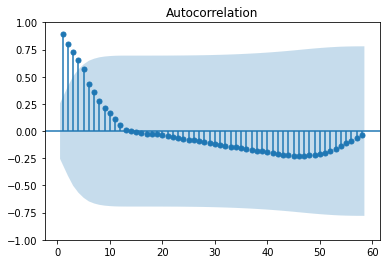

In [112]:
sgt.plot_acf(train_df[['GDP (current US$)']], zero = False, lags = 58)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


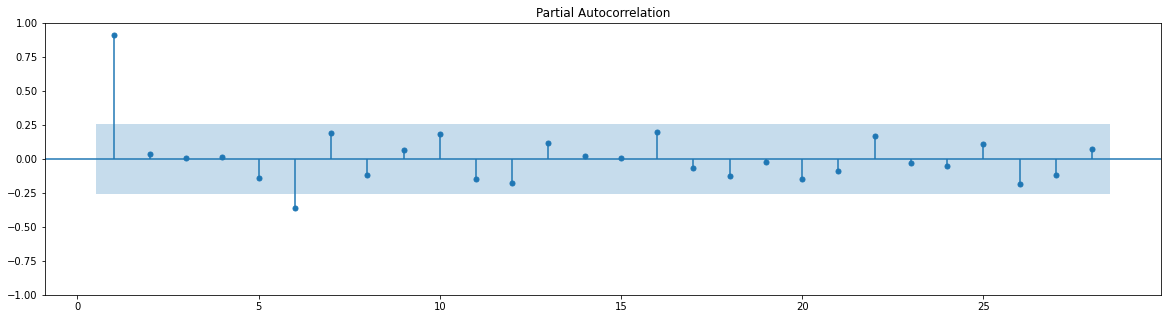

In [113]:
plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_pacf(train_df[['GDP (current US$)']], zero = False, lags = 28)
plt.show()

In [114]:
adfuller(train_df["GDP (current US$)"])

(0.803007332698011,
 0.9916845572455877,
 10,
 48,
 {'1%': -3.5745892596209488,
  '5%': -2.9239543084490744,
  '10%': -2.6000391840277777},
 2194.307284305165)

Статистика теста больше всех критических значений, поэтому нулевую гипотезу ($H_0$) нельзя отвергнуть.

Поэтому значения GDP не являются стационарными

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


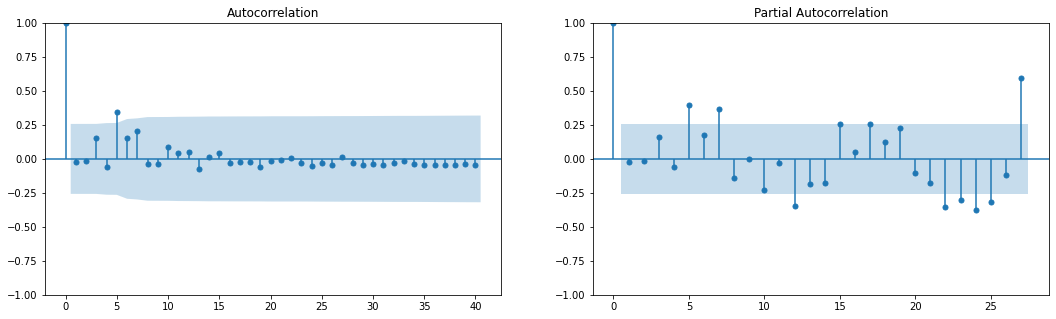

(-1.8255652246436023,
 0.367845152765633,
 7,
 50,
 {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616},
 2147.2038799920597)

In [115]:
plot_acf_pacf(train_df["GDP (current US$)"].diff(1).dropna())
adfuller(train_df["GDP (current US$)"].diff(1).dropna())

Первые разности не являются стационарыми

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


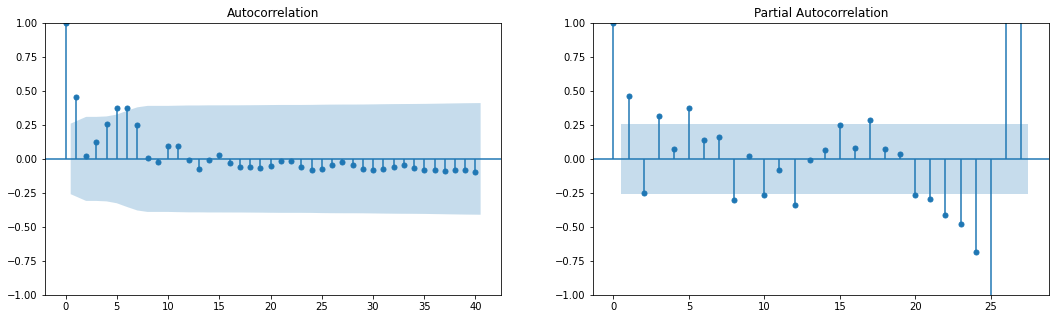

(-3.9998034409491505,
 0.001411540843666124,
 11,
 45,
 {'1%': -3.584828853223594,
  '5%': -2.9282991495198907,
  '10%': -2.6023438271604937},
 2097.033254524892)

In [127]:
plot_acf_pacf(train_df["GDP (current US$)"].diff(2).dropna())
adfuller(train_df["GDP (current US$)"].diff(2).dropna())

Вторые разности являются стационарыми

In [128]:
ar_model = AutoReg(train_df["GDP (current US$)"].dropna(), lags=5).fit()
ar_model.summary()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                     AutoReg(5)   Log Likelihood               -1263.925
Method:               Conditional MLE   S.D. of innovations     3538875348.324
Date:                Thu, 13 Oct 2022   AIC                           2541.849
Time:                        11:47:33   BIC                           2555.772
Sample:                    01-01-1965   HQIC                          2547.219
                         - 01-01-2018                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 2.479e+08   6.08e+08      0.407      0.684   -9.45e+08    1.44e+09
GDP (current US$).L1     0.8863      0.132      6.727      0.000       0.628       1.145
GDP (current US$).L2    -0.0302      0.175     -0.172      0.863      -0.373       0.313
GDP (current US$).L3     0.2170      0.173      1.253      0.210      -0.122       0.556
GDP (current US$).L4    -0.2520      0.184     -1.366      0.172      -0.613       0.109
GDP (current US$).L5     0.3315      0.157      2.109      0.035       0.023       0.640
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.9218           -0.0000j            0.9218           -0.0000
AR.2           -0.8811           -0.9642j            1.3061           -0.3678
AR.3           -0.8811           +0.9642j            1.3061            0.3678
AR.4            0.8003           -1.1303j            1.3850           -0.1519
AR.5            0.8003           +1.1303j            1.3850            0.1519
-----------------------------------------------------------------------------
"""

In [131]:
arima_model = ARIMA(train_df["GDP (current US$)"].diff(2).dropna(), order = (5, 2, 6))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible start

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   57
Model:                 ARIMA(5, 2, 6)   Log Likelihood               -1289.038
Date:                Thu, 13 Oct 2022   AIC                           2602.077
Time:                        11:49:01   BIC                           2626.165
Sample:                    01-01-1962   HQIC                          2611.392
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5072      2.708      0.187      0.851      -4.801       5.815
ar.L2         -0.9806      0.487     -2.015      0.044      -1.934      -0.027
ar.L3          0.2237      3.185      0.070      0.944      -6.019       6.467
ar.L4         -0.5331      0.480     -1.111      0.267      -1.474       0.407
ar.L5          0.1709      3.084      0.055      0.956      -5.874       6.216
ma.L1         -1.6888      3.399     -0.497      0.619      -8.351       4.974
ma.L2          1.0086      4.659      0.216      0.829      -8.123      10.140
ma.L3          0.1437      2.945      0.049      0.961      -5.629       5.917
ma.L4         -1.1263      1.114     -1.011      0.312      -3.310       1.057
ma.L5          1.3114      1.206      1.087      0.277      -1.053       3.676
ma.L6         -0.6129      0.672     -0.913      0.361      -1.929       0.703
sigma2      1.903e+19        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                52.25
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):             159.70   Skew:                             0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.92e+54. Standard errors may be unstable.
"""

Получили, что критерий AIC для модели на интерполированных данных вырос по сравнению с моделью на неинтерполированных данных, в виду появления новых данных, которые ранее равнялись нулю

### Волатильность

In [132]:
data["GDP (current US$)_vol"] = data['GDP (current US$)'].pct_change(1).mul(100).abs()
data["GDP (current US$)_vol"].head()

year
1960-01-01          NaN
1961-01-01     0.000000
1962-01-01    13.578826
1963-01-01    11.448835
1964-01-01    12.363636
Name: GDP (current US$)_vol, dtype: float64

<AxesSubplot:xlabel='year'>

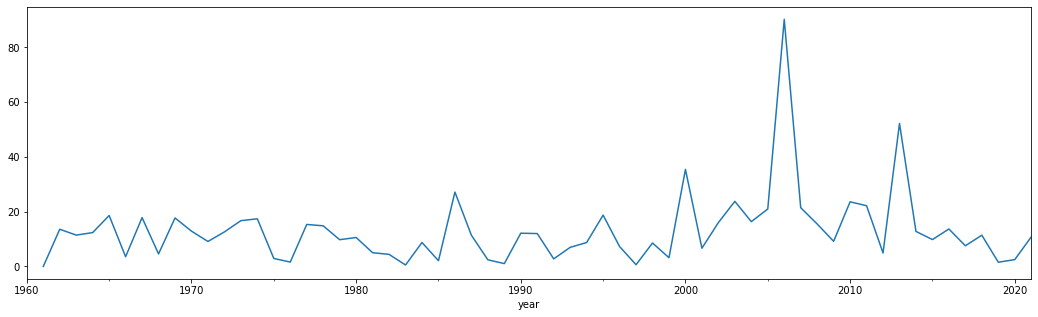

In [133]:
data["GDP (current US$)_vol"].plot()

По графику волатильности можно заметить, что дисперсия в основном колеблется от 0 до 20, а примерно в 2005-2006 годах она очень велика (выше 80)

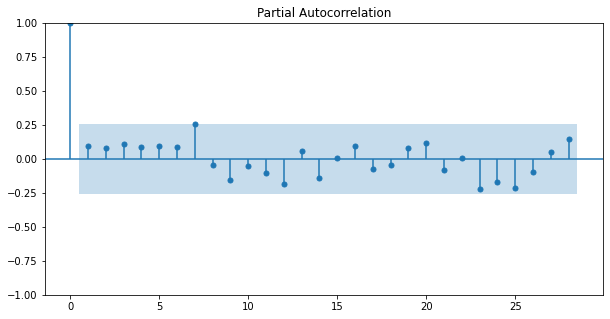

In [135]:
test_df = data.iloc[-3:]
train_df = data.iloc[:-3]

plt.rcParams["figure.figsize"] = 10, 5

sgt.plot_pacf(train_df[["GDP (current US$)_vol"]][1:], lags = 28)
plt.show()

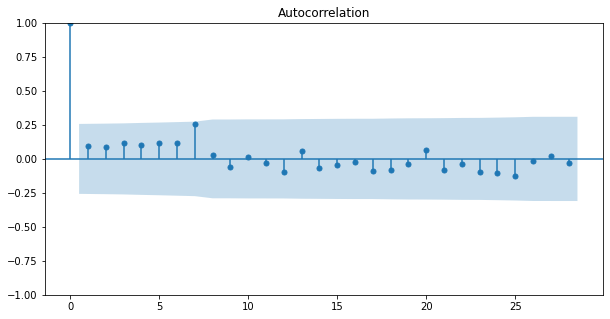

In [138]:
sgt.plot_acf(train_df[["GDP (current US$)_vol"]][1:], lags = 28)
plt.show()

In [136]:
adfuller(train_df[["GDP (current US$)_vol"]][1:])

(-6.816105099260228,
 2.0572875762632108e-09,
 0,
 57,
 {'1%': -3.5506699942762414,
  '5%': -2.913766394626147,
  '10%': -2.5946240473991997},
 382.739595975669)

Глядя на график частичной корреляции для волатильности, все значения лагов очень небольшие (менее 0.25), и самый значительный 7 лаг.

In [137]:
# нам важно сохранить объем датасета, поэтому берем за исходные данные весь датасет с индексами, который содержит
# и train и test часть
garch_df = pd.DataFrame(data["GDP (current US$)_vol"].loc[data.index]) 

garch_df.at[train_df.index, "GDP (current US$)_vol"] = train_df["GDP (current US$)_vol"].dropna()

In [149]:
from arch import arch_model
model = arch_model(garch_df["GDP (current US$)_vol"].dropna(), p = 7, q = 1, vol = "GARCH")

# в параметре last_obs указываем последний объект, до которого будем совершать обучение. 
# в нашем случае это до первого объекта из test выборки 

model_results = model.fit(last_obs = test_df.index[0], update_freq = 5)

Iteration:      5,   Func. Count:     61,   Neg. LLF: 225.83149885192793
Iteration:     10,   Func. Count:    118,   Neg. LLF: 216.29923992049723
Iteration:     15,   Func. Count:    173,   Neg. LLF: 214.7350475025919
Optimization terminated successfully    (Exit mode 0)
            Current function value: 214.7350320922951
            Iterations: 17
            Function evaluations: 195
            Gradient evaluations: 17


In [150]:
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Constant Mean - GARCH Model Results                       
=================================================================================
Dep. Variable:     GDP (current US$)_vol   R-squared:                       0.000
Mean Model:                Constant Mean   Adj. R-squared:                  0.000
Vol Model:                         GARCH   Log-Likelihood:               -214.735
Distribution:                     Normal   AIC:                           449.470
Method:               Maximum Likelihood   BIC:                           470.074
                                           No. Observations:                   58
Date:                   Thu, Oct 13 2022   Df Residuals:                       57
Time:                           12:05:15   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            11.7883      1.239      9.511  1.895e-21 [  9.359, 14.218]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega         45.3484     15.170      2.989  2.796e-03      [ 15.616, 75.081]
alpha[1]   1.4550e-11  1.984e-02  7.332e-10      1.000 [-3.889e-02,3.889e-02]
alpha[2]   6.2374e-11  1.336e-02  4.668e-09      1.000 [-2.619e-02,2.619e-02]
alpha[3]   1.5405e-11  2.886e-02  5.338e-10      1.000 [-5.656e-02,5.656e-02]
alpha[4]   3.4273e-03  4.777e-03      0.717      0.473 [-5.935e-03,1.279e-02]
alpha[5]   1.0515e-11  8.667e-03  1.213e-09      1.000 [-1.699e-02,1.699e-02]
alpha[6]       0.7280      0.481      1.515      0.130      [ -0.214,  1.670]
alpha[7]       0.1023      0.125      0.819      0.413      [ -0.142,  0.347]
beta[1]    1.1774e-10      0.125  9.452e-10      1.000      [ -0.244,  0.244]
=============================================================================

Covariance estimator: robust
"""

In [151]:
predictions_df = test_df.copy()
predictions_df["Predictions"] = model_results.forecast().residual_variance.loc[test_df.index]

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


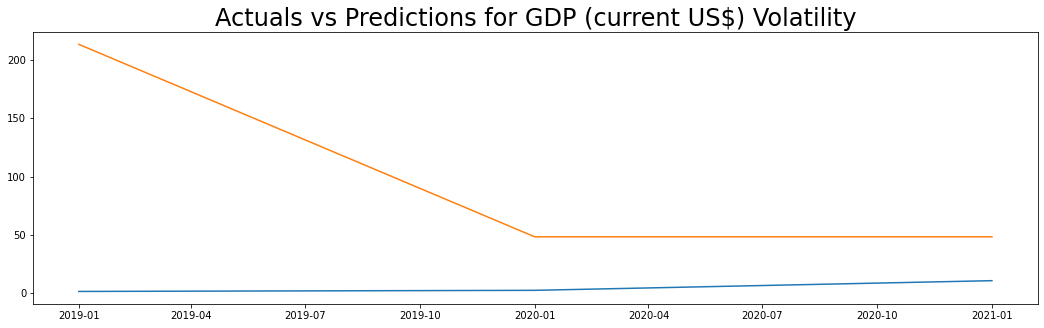

In [152]:
plt.rcParams["figure.figsize"] = 18, 5

plt.plot(predictions_df["GDP (current US$)_vol"].abs())
plt.plot(predictions_df["Predictions"])

plt.title("Actuals vs Predictions for GDP (current US$) Volatility", size = 24)

plt.show()

Получили,что полученная модель не уловила дисперсию, и плохо предсказала результат. Это могло возникнуть из-за небольшого количества данных (около 62), и из-за поведения данных, т.е мы только наблюдаем увеличение показателя GDP данных, у нас нет случаев убывания или возрастания, и тестовые значения были новыми для модели. 